# Lab 3: Gravity corrections

Name:

Date:

All the tasks in this lab are:
* Use your terrain forward modeling from Lab 2 to create a Bouguer disturbance - 4 pt
* Make an isostatic disturbance accounting for ice - 6 pt

Total = 10 pts

The first part of this lab is a demonstration making Bouguer and isostatic corrections to gravity data. The data used here is a global gravity model calculated up to 10 km above the surface. 
After the demo portion you will be responsible for using your Lab 2 forward modeling code to create a complete Bouguer disturbance and formard model an isostatic correction to calculate the isostatic disturbance.

In [1]:
# for gravity
import boule as bl
import harmonica as hm

# for data manipulation and plotting
import verde as vd
import xarray as xr
import xrft
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmocean

# for sample datasets
import ensaio

from pathlib import Path

# custom bathymetry and topo colormap
from utilities import get_topo_cm
topo_cm = get_topo_cm()

## Load demo datasets and combine into xarray

In [2]:
# get sample global gravity, geoid, and topo
fname_gravity = ensaio.fetch_earth_gravity(version=1)
fname_geoid = ensaio.fetch_earth_geoid(version=1)
fname_topo = ensaio.fetch_earth_topography(version=1)

# merge different dataarrays in single xarray Dataset
data = xr.merge(
    [
        xr.load_dataarray(fname_gravity),
        xr.load_dataarray(fname_geoid),
        xr.load_dataarray(fname_topo),
    ]
)

# coarsen the dataset
data = data.coarsen(latitude=4, longitude=4, boundary='pad').mean()

data

<xarray.Dataset> Size: 4MB
Dimensions:     (latitude: 271, longitude: 541)
Coordinates:
  * longitude   (longitude) float64 4kB -179.8 -179.1 -178.4 ... 179.6 180.0
  * latitude    (latitude) float64 2kB -89.75 -89.08 -88.42 ... 88.92 89.58 90.0
    height      (latitude, longitude) float32 586kB 1e+04 1e+04 ... 1e+04 1e+04
Data variables:
    gravity     (latitude, longitude) float64 1MB 9.801e+05 ... 9.802e+05
    geoid       (latitude, longitude) float64 1MB -29.57 -29.57 ... 15.4 15.4
    topography  (latitude, longitude) float64 1MB 2.801e+03 ... -4.237e+03
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

/Users/holden/miniforge3/envs/cryo/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


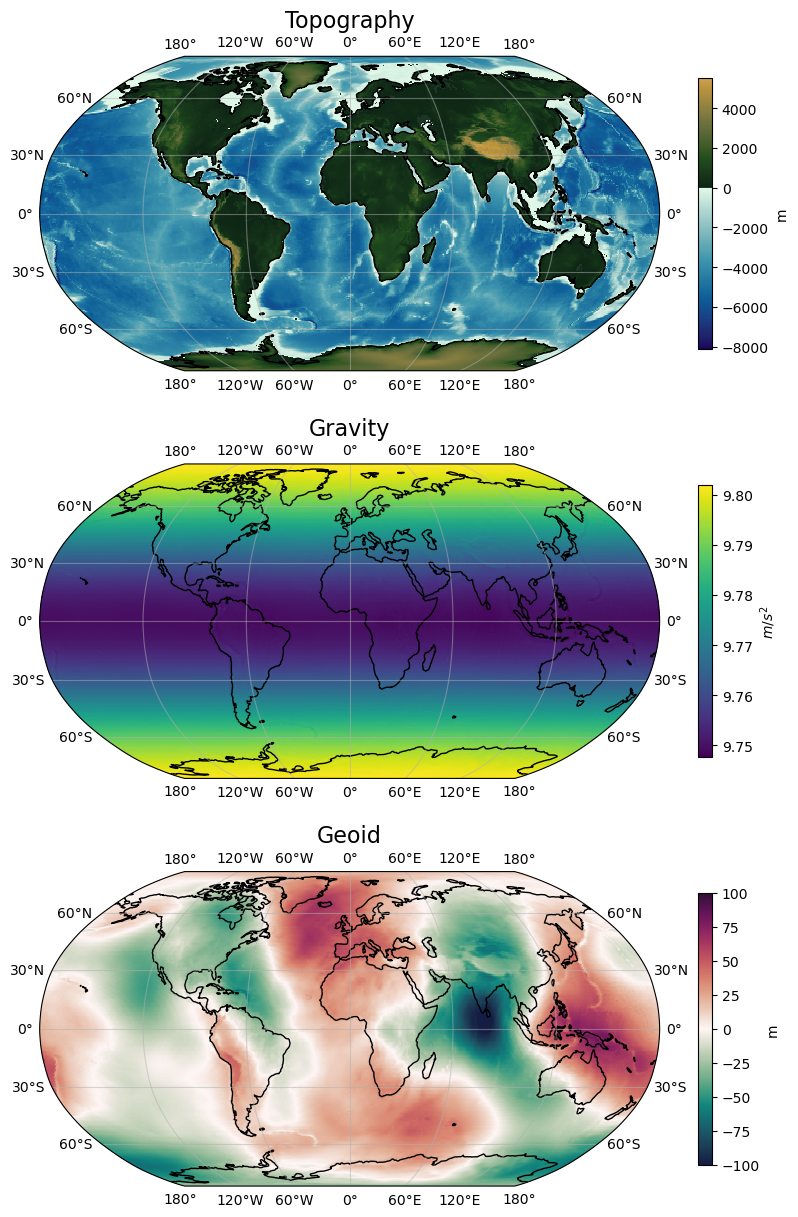

In [3]:
# download the utilities.py from Canvas and put it in the same folder as this notebook
from utilities import get_topo_cm

topo_cm = get_topo_cm()

# find the min and max to make a custom colormap
topo_min = np.min(data.topography)
topo_max = np.max(data.topography)
topo_clip = cmocean.tools.crop(topo_cm, topo_min, topo_max, 0)

cb_shrink = 0.8

# make subplots in Robinson projection
fig, axs = plt.subplots(3, 1, figsize=(10,15), subplot_kw=dict(projection=ccrs.Robinson()))

# plot topogrpahy
ax = axs[0]
im = ax.pcolormesh(data.longitude, data.latitude, data.topography, 
                   cmap=topo_clip, transform=ccrs.PlateCarree())
ax.set_title('Topography', fontsize=16)
plt.colorbar(im, ax=ax, label='m', shrink=cb_shrink)

# plot gravity
ax = axs[1]
im = ax.pcolormesh(data.longitude, data.latitude, data.gravity/1e5, 
                   cmap='viridis', transform=ccrs.PlateCarree())
ax.set_title('Gravity', fontsize=16)
plt.colorbar(im, ax=ax, label=r'$m/s^2$', shrink=cb_shrink)

# plot geoid
ax = axs[2]
im = ax.pcolormesh(data.longitude, data.latitude, data.geoid, 
                   cmap=cmocean.cm.curl, vmin=-100, vmax=100, transform=ccrs.PlateCarree())
ax.set_title('Geoid', fontsize=16)
plt.colorbar(im, ax=ax, label='m', shrink=cb_shrink)

# add coastlines and gridlines
for ax in axs:
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)

plt.show()

## Some observations:

* We can't see much in the gravity data!
* The gravity signal is stronger near the poles and weakeast at the equator
* The geoid is not correlated with the ocean basins. We might expect this because of the large difference in density between rock and water, however this is not the case. This is largely explained by isostasy compensating for the lower density of the oceans. That is, the lower density of the oceans is offset by the higher density of the mantle being shallower under the thin oceanic crust
* You might notice a giant gravity "hole" near India. This is the Indian Ocean Geoid Low (IOGL) and has been the subject of study since it's discovery. A paper last year used modeling to show that the IOGL likely formed due to hot and low-density mantle plumes extending all the way from the outer core: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL102694

## First correction: Removing normal gravity to make a gravity disturbance

Normal gravity is the gravity due to the rotating ellipsoid. As we can see in the original data, the signal is dominated by the normal gravity. Removing normal gravity is our first step where we produce a disturbance or an anomaly, something that can tell us about the variations in the Earth's gravity field.

**In this step we are removing the normal gravity felt at the observation height (10 km). Thus, we are combining the tradition normal gravity and free-air corrections.**

In [4]:
# Calculate normal gravity and the disturbance
ellipsoid = bl.WGS84
gamma = ellipsoid.normal_gravity(data.latitude, data.height)
disturbance = data.gravity - gamma

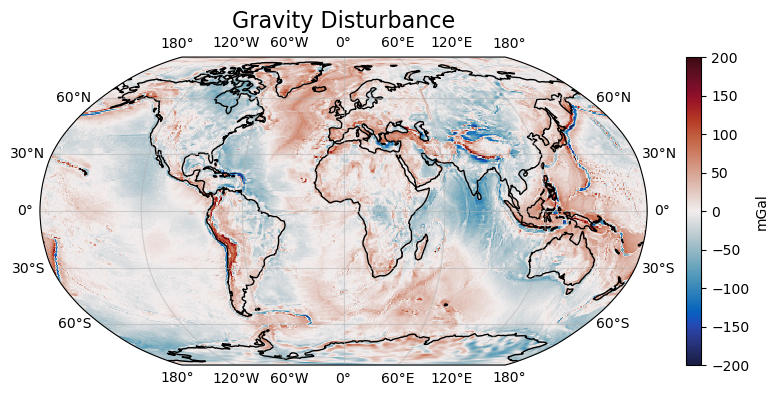

In [5]:
balance = cmocean.cm.balance

fig, ax = plt.subplots(1, 1, figsize=(10,4), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines()
im = ax.pcolormesh(data.longitude, data.latitude, disturbance, 
                   transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap=balance)
ax.set_title('Gravity Disturbance', fontsize=16)
plt.colorbar(im, ax=ax, label='mGal')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
plt.show()

## Some observations:

* Now we see positive and negative gravity disturbances
* The gravity disturbance is highly correlated with topography. We see strong positive disturbances in the Himalaya, the Andes, and the Rocky Mountains. If you look closely, you can see strong negative anomalies at subduction trenches. For instance, must of the West coast of central and South America has a trench, and the Mariana Trench near Japan produces a clear disturbance.
* Mid-ocean ridges also produce strong positive anomalies. These ridges have higher topography, and higher density mantle material coming all the way to the surface.

If we are interested in the density of the subsurface, we want to remove the effect of the topography with a Bouguer correction.

## Simple Bouguer correction

The Bouguer slab formula for positive topography is: 

$$ g_{bg} = 2 \pi \gamma \rho h $$

in which $\gamma$ is the gravitational constant and $g_{bg}$ is the
gravitational effect of an infinite plate of thickness $h$ (topography) and
density $\rho$. In the oceans it is:

$$ g_{bg} = 2 \pi \gamma (\rho_w - \rho_c) |h| $$

in which $\rho_w$ is the density of water and $\rho_c$ is the
density of the crust of the normal Earth.

In [6]:
from choclo.constants import GRAVITATIONAL_CONST

# Reference the topography to the ellipsoid
topography_ell = data.topography + data.geoid

# densities
rho_terrain = 2670
rho_water = 1030

# positive topography
boug_corr_pos = 2*np.pi*GRAVITATIONAL_CONST*rho_terrain*topography_ell*1e5

# ocean
boug_corr_neg = 2*np.pi*GRAVITATIONAL_CONST*(rho_water-rho_terrain)*np.abs(topography_ell)*1e5

# where topography above 0, use positive, otherwise use ocean
bouguer = np.where(topography_ell > 0, boug_corr_pos, boug_corr_neg)

# remove Bouguer from disturbance
disturbance_topofree = disturbance-bouguer

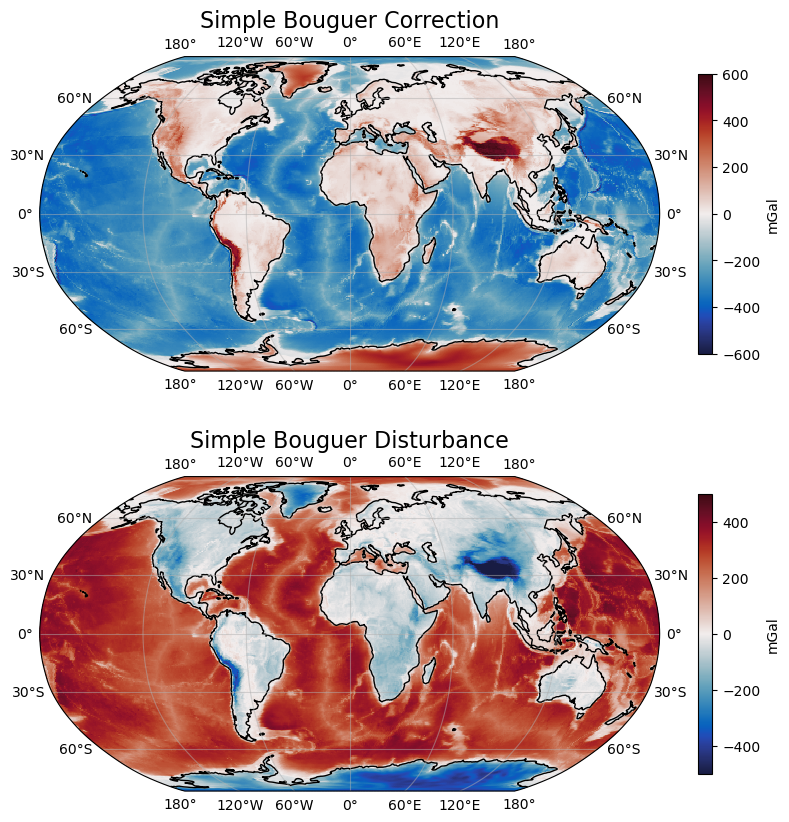

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson()))

ax = axs[0]
im = ax.pcolormesh(data.longitude, data.latitude, bouguer, cmap=balance, vmin=-600, vmax=600, 
                   transform=ccrs.PlateCarree())
ax.set_title('Simple Bouguer Correction', fontsize=16)
plt.colorbar(im, ax=ax, label='mGal', shrink=cb_shrink)

ax = axs[1]
im = ax.pcolormesh(data.longitude, data.latitude, disturbance_topofree, cmap=balance, vmin=-500, vmax=500, 
                   transform=ccrs.PlateCarree())
ax.set_title('Simple Bouguer Disturbance', fontsize=16)
plt.colorbar(im, ax=ax, label='mGal', shrink=cb_shrink)

for ax in axs:
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
plt.show()

## Some observations:

* We can see the Bouguer correction has more positive values for higher topography and lower values for deeper points in the oceans
* The simple Bouguer disturbance now has positive values in the oceans and negative values on land. This is because our corrections haven't accounted for isostasy.
* However, if you focus on mid-ocean ridges, we can see how removing the effect of topography has made the mid-ocean ridges more visible.
* Note the large magnitude of the Bouguer Disturbance
* Also note that the Bouguer slab assumed an infinite slab of terrain at that elevation. This assumption works well in a place like Kansas where is topography above sea level is approximately an infinite slab, howver in areas of high relief this assumption introduces errors. With traditional gravity anomalies, a simple Bouguer correction would be followed by a terrain correction to correct for these effects.

## We can calculate the Airy isostatic moho depth that we would use for an isostatic correction

The isostatic correction aims to correct the Bouguer disturbance for isostasy. Remember that under the oceans there should be shallower mantle material and under the continents are "mountain roots" isostatically supporting the terrain.

The isostatic moho depth is the theoretical depth at which excesses or defecits of masses from topography or oceans will be compensated by a deeper or shallower mantle.

Over the continent the Airy root can be found with:

$$ r = r_0 + \frac{\rho_{c}}{\rho_m - \rho_{c}} h $$

Where $r$ is the root depth, $r_0$ is the reference moho depth, $\rho_{c}$ is the crust density, $\rho_{m}$ is the mantle density, and $h$ is the topography. Over the ocean basins the antiroot can be found with:

$$ r = r_0 + \frac{\rho_{c}-\rho_w}{\rho_m - \rho_{c}} h $$

Where $\rho_w$ is the density of seawater. Use a crustal density of 2800 $kg/m^3$, a mantle density of 3300 $kg/m^3$, and seawater density of 1030 $kg/m^3$. Use a $r_0$ of 30 km. The depths should be positive.

In [8]:
# densities
rho_water = 1030
rho_crust = 2800
rho_mantle = 3300
ref_moho = 30e3

# calculate the airy moho depth
r_continent = rho_crust/(rho_mantle-rho_crust)*topography_ell
r_ocean = (rho_crust-rho_water)/(rho_mantle-rho_crust)*topography_ell
r_airy = np.where(topography_ell > 0, r_continent, r_ocean)
r_airy += ref_moho

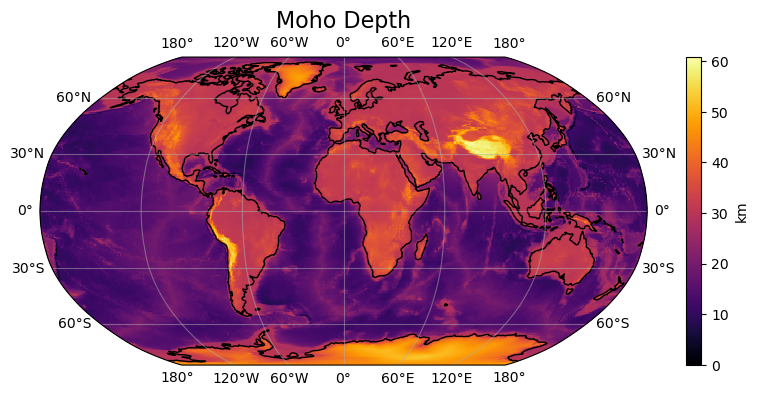

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines()
im = ax.pcolormesh(data.longitude, data.latitude, r_airy/1000, cmap='inferno', vmin=0,
                   transform=ccrs.PlateCarree())
ax.set_title('Moho Depth', fontsize=16)
plt.colorbar(im, ax=ax, label='km')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
plt.show()

## The isostatic correction requires forward modeling, so let's zoom into a smaller region so we can model this

* A good size is about 40$\degree$-60$\degree$ in latitude and longitude
* Use the `ccrs.PlateCarree()` projection
* An area with significant topography near a coast will be the most interesting
* Don't use Antarctica or Greenland for this, as we are not accounting for ice right now

In [10]:
# add arrays to Dataset
data['disturbance'] = (('latitude', 'longitude'), disturbance.data)
data['bouguer'] = (('latitude', 'longitude'), bouguer.data)
data['moho'] = (('latitude', 'longitude'), r_airy)
data['topography_ell'] = (('latitude', 'longitude'), topography_ell.data)

# trim to region
region = (-95, -55, 0, -40)
data_aoi = data.sel(latitude=slice(region[3], region[2]), longitude=slice(*region[:2]))
data_aoi

<xarray.Dataset> Size: 217kB
Dimensions:         (latitude: 60, longitude: 60)
Coordinates:
  * longitude       (longitude) float64 480B -94.42 -93.75 ... -55.75 -55.08
  * latitude        (latitude) float64 480B -39.75 -39.08 ... -1.083 -0.4167
    height          (latitude, longitude) float32 14kB 1e+04 1e+04 ... 1e+04
Data variables:
    gravity         (latitude, longitude) float64 29kB 9.771e+05 ... 9.749e+05
    geoid           (latitude, longitude) float64 29kB -2.313 -1.906 ... -23.03
    topography      (latitude, longitude) float64 29kB -3.372e+03 ... 431.2
    disturbance     (latitude, longitude) float64 29kB 2.633 3.515 ... -11.93
    bouguer         (latitude, longitude) float64 29kB -232.0 -222.5 ... 45.71
    moho            (latitude, longitude) float64 29kB 1.806e+04 ... 3.229e+04
    topography_ell  (latitude, longitude) float64 29kB -3.374e+03 ... 408.2
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

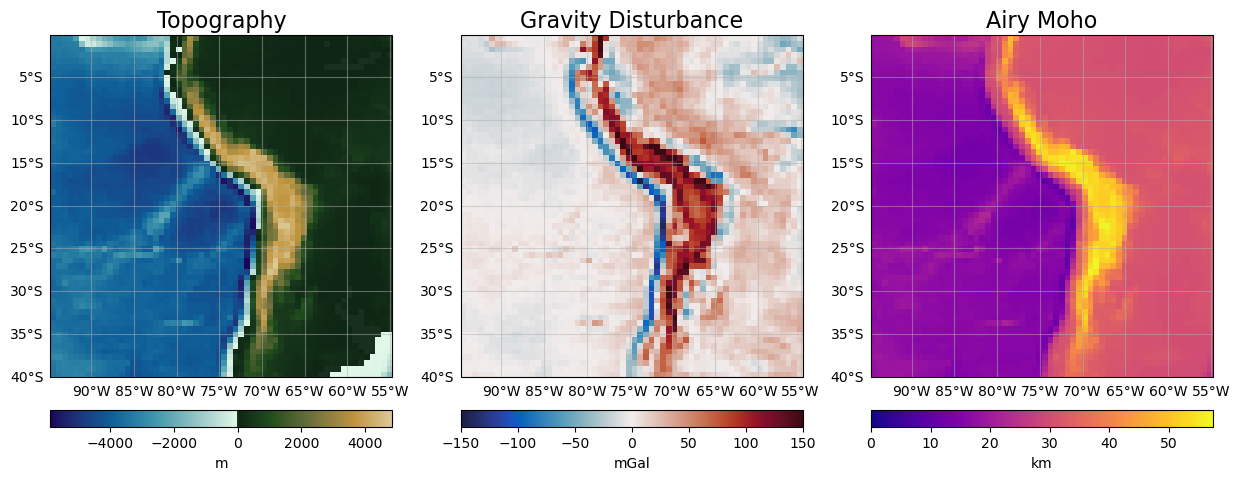

In [11]:
topo_min = np.min(data_aoi.topography.values)
topo_max = np.max(data_aoi.topography.values)
topo_trim = cmocean.tools.crop(topo_cm, topo_min, topo_max, 0)

fig, axs = plt.subplots(1, 3, figsize=(15,6), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax = axs[0]
im = ax.pcolormesh(data_aoi.longitude, data_aoi.latitude, data_aoi.topography, cmap=topo_trim)
ax.axis('scaled')
ax.set_title('Topography', fontsize=16)
plt.colorbar(im, ax=ax, label='m', pad=0.07, location='bottom', orientation='horizontal')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax = axs[1]
im = ax.pcolormesh(data_aoi.longitude, data_aoi.latitude, data_aoi.disturbance, cmap=balance, vmin=-150, vmax=150)
ax.axis('scaled')
ax.set_title('Gravity Disturbance', fontsize=16)
plt.colorbar(im, ax=ax, label='mGal', pad=0.07, location='bottom', orientation='horizontal')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax = axs[2]
im = ax.pcolormesh(data_aoi.longitude, data_aoi.latitude, data_aoi.moho/1000, cmap='plasma', vmin=0)
ax.axis('scaled')
ax.set_title('Airy Moho', fontsize=16)
plt.colorbar(im, ax=ax, label='km', pad=0.07, location='bottom', orientation='horizontal')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
gl.right_labels = False
gl.top_labels = False

plt.show()

## We will forward model the terrain effect to make a complete Bouguer disturbance

We are using tesseroids because our data are in latitude and longitude coordinates, and we are looking at a really large area. The sides of tesseroids are lines of latitude and longitude and the tops and bottoms are radii distances from the center of the Earth. For large study areas such as we are doing, it is good to use tesseroids becuase the curvature of the Earth can become important. If you assume a flat grid you might introduce some error. Tesseroids are basically spherical prisms.

For both the complete Bouguer disturbance and the isostatic residual, we will be using the `harmonica.tesseroid_layer` function. This function is useful in these situtations because you can use a reference datum or surface and have tesseroids with different densities above and below the reference surface. This is true for both of our situations: for the complete Bouguer we have the effect of terrain above the ellipsoid and water below it, for the isostatic residual we have the effect of the Airy root and anti-root.

In [16]:
longitude, latitude = np.meshgrid(data_aoi.longitude, data_aoi.latitude)

# our computation points are 10km above the ellipsoid
grid_radius = ellipsoid.geocentric_radius(latitude)+10e3
grid_coords = (longitude, latitude, grid_radius)

density_boug = xr.where(data_aoi.topography_ell>=0, 2670, 1030 - 2670)

# Create layer of tesseroids for complete Bouguer
tesseroids = hm.tesseroid_layer(
    coordinates=(data_aoi.longitude, data_aoi.latitude),
    surface=ellipsoid.geocentric_radius(latitude)+data_aoi.topography_ell,
    reference=ellipsoid.geocentric_radius(latitude),
    properties={"density": density_boug},
)

# Compute gravity field of tesseroids on a regular grid of observation points
gravity_terrain = tesseroids.tesseroid_layer.gravity(grid_coords, field="g_z")
complete_boug = data_aoi.disturbance-gravity_terrain

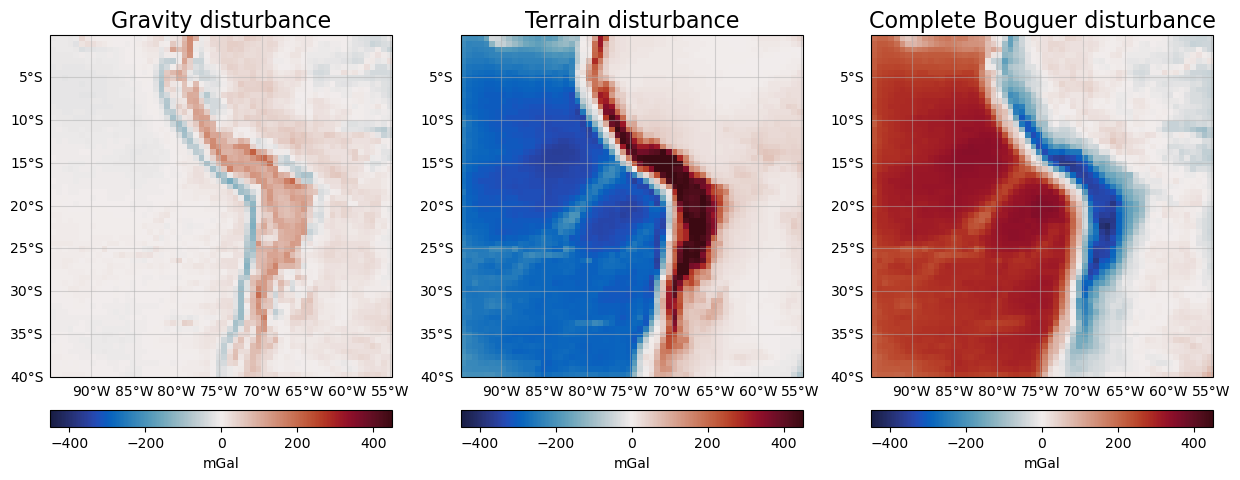

In [17]:
plots = [data_aoi.disturbance, gravity_terrain, complete_boug]
titles = ['Gravity disturbance', 'Terrain disturbance', 'Complete Bouguer disturbance']

fig, axs = plt.subplots(1, 3, figsize=(15,6), subplot_kw=dict(projection=ccrs.PlateCarree()))

for ax, plot, title in zip(axs, plots, titles):
    im = ax.pcolormesh(data_aoi.longitude, data_aoi.latitude, plot, cmap=balance, vmin=-450, vmax=450)
    ax.axis('scaled')
    ax.set_title(title, fontsize=16)
    plt.colorbar(im, ax=ax, label='mGal', pad=0.07, location='bottom', orientation='horizontal')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False

plt.show()

## Let's forward model the isostatic correction and calculate the isostatic disturbance

Here we are forward modeling the excess of deficit of mantle material according to our Airy moho depth. We assumed a reference depth of 30 km so where the depth is less than 30 km we will have a positive density contrast and greater than 30 km we will have a negative density contrast.

In [18]:
# Compute gravity field of tesseroids on a regular grid of observation points
gravity_boug = tesseroids.tesseroid_layer.gravity(grid_coords, field="g_z")

# find radii of tesseroids
reference = ellipsoid.geocentric_radius(latitude)-ref_moho
surface = ellipsoid.geocentric_radius(latitude)-data_aoi.moho
density = xr.where(data_aoi.moho > ref_moho, rho_crust-rho_mantle, rho_mantle-rho_crust)

tesseroids = hm.tesseroid_layer(
    coordinates=(data_aoi.longitude, data_aoi.latitude),
    surface=surface,
    reference=reference,
    properties={"density": density},
)

# Compute gravity field of tesseroids on a regular grid of observation points
iso_corr = tesseroids.tesseroid_layer.gravity(grid_coords, field="g_z")
iso_disturbance = complete_boug-iso_corr

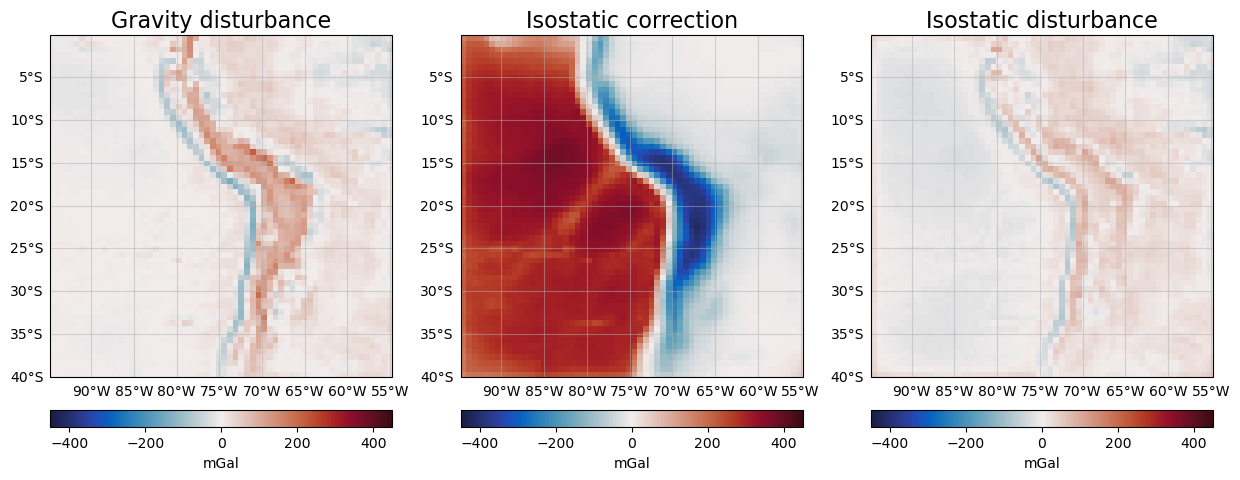

In [19]:
plots = [data_aoi.disturbance, iso_corr, iso_disturbance]
titles = ['Gravity disturbance', 'Isostatic correction', 'Isostatic disturbance']

fig, axs = plt.subplots(1, 3, figsize=(15,6), subplot_kw=dict(projection=ccrs.PlateCarree()))

for ax, plot, title in zip(axs, plots, titles):
    im = ax.pcolormesh(data_aoi.longitude, data_aoi.latitude, plot, cmap=balance, vmin=-450, vmax=450)
    ax.axis('scaled')
    ax.set_title(title, fontsize=16)
    plt.colorbar(im, ax=ax, label='mGal', pad=0.07, location='bottom', orientation='horizontal')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False

plt.show()

## Some observations:

* We can see that the isostatic correction is almost the opposite of the Bouguer terrain correction and this shows what isostasy is doing.
* The isostatic disturbance looks similar to the (free-air) gravity disturbance.
* We can now start making interpretations about subsurface density. You'll notice that we still see disturbances correlated with terrain. For instance, the trench still shows a negative anomaly, however this could be due to the accumulation of sediment in the trench
* We might have effects from errors in our topography
* The assumption of Airy isostasy and the densities we use could introduce bias

# Now you will apply these corrections to your gravity data

## Use your terrain forward modeling from Lab 2 to create a Bouguer disturbance - 4 pt

Copy your forward modeling code or save your terrain effect to your csv file in Lab 2.

* Subtract the foward modeling from Lab from your free air anomaly to get the Bouguer disturbance
* **Make a figure with 3 subplots: your free air anomaly, gravity due to terrain, and the Bouguer disturbace**

Follow the numbered steps below:

### 1. Load your BedMachine and gravity data

In [21]:
# Load BedMachine dataset (NetCDF format)
bedmachine_path = '/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_bedmachine_dataset_polar_stereo.nc'

bedmachine = xr.open_dataset(bedmachine_path)

bedmachine['bed_ell'] = bedmachine['bed'] + bedmachine['geoid']
bedmachine['surface_ell'] = bedmachine['surface'] + bedmachine['geoid']

gravity_data_path = '/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/final_gravity_dataset.csv'

gravity_data = pd.read_csv(gravity_data_path)

required_vars = ['thickness', 'x', 'y', 'mask']

required_gravity_cols = ['polar_stereo_x', 'polar_stereo_y', 'faa140', 'measurement_height']

### 2. Forward model the terrain effect (or save it in Lab 2 and load it here)

With prisms, same as before. We are not using tesseroids

In [23]:
# Load the terrain effect data exported from Lab 2
terrain_effect_path = '/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/terrain_effect.csv'

terrain_effect_df = pd.read_csv(terrain_effect_path)

required_columns = ['polar_stereo_x', 'polar_stereo_y', 'g_total']

### 3. Subtract the terrain effect from the free air anomaly to make the Bouguer disturbance and make the figure

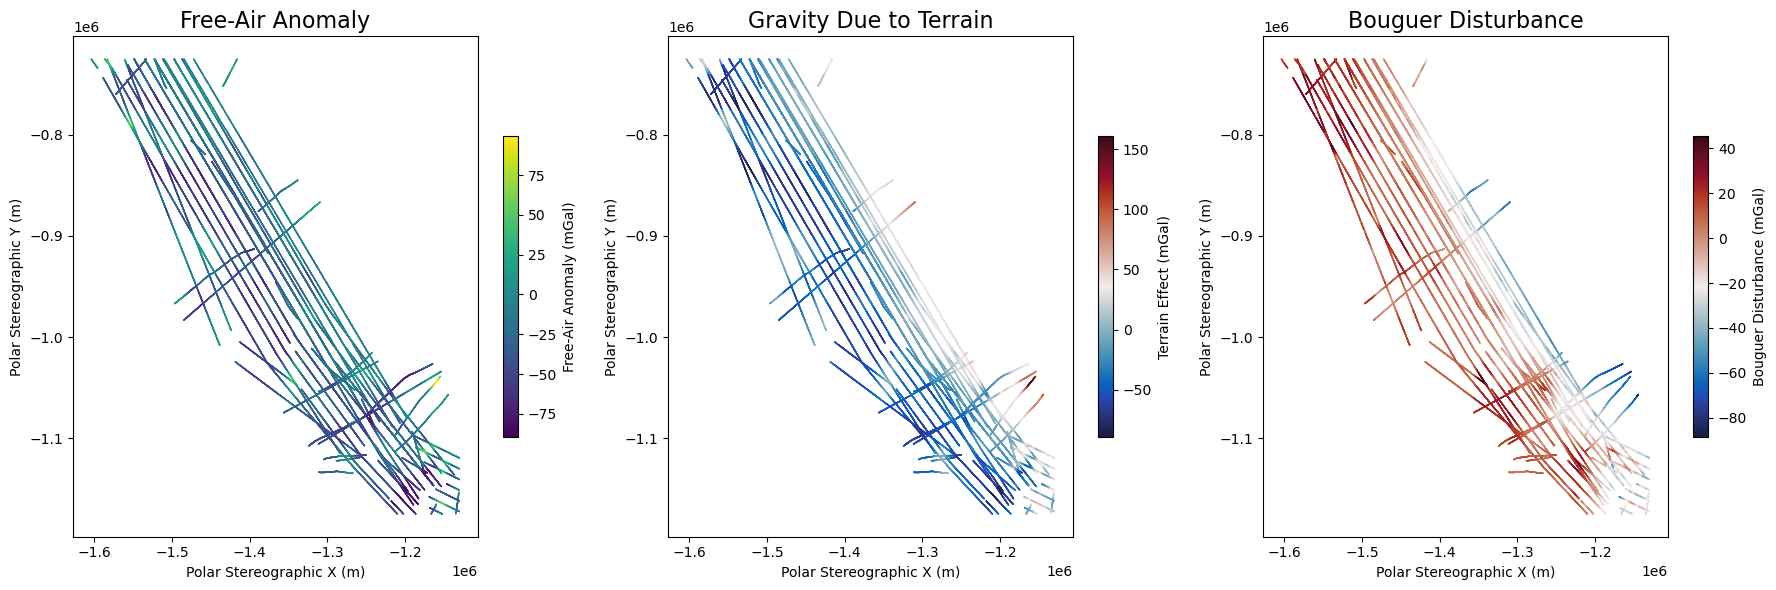

In [25]:
#Merge the gravity data and terrain effect data on coordinates
merged_data = pd.merge(
    gravity_data,
    terrain_effect_df,
    on=['polar_stereo_x', 'polar_stereo_y'],
    how='inner'
)

#Check for any missing values
if merged_data.isnull().values.any():
    print("Warning: Missing values detected in merged data. Dropping missing values.")
    merged_data.dropna(inplace=True)

#Extract free-air anomaly and terrain effect
free_air_anomaly = merged_data['faa140'].values
terrain_effect = merged_data['g_total'].values

#Compute Bouguer Disturbance
bouguer_disturbance = free_air_anomaly - terrain_effect

#Add Bouguer Disturbance to the DataFrame
merged_data['bouguer_disturbance'] = bouguer_disturbance

#Save the Bouguer Disturbance to a CSV file
bouguer_disturbance_path = '/Users/holden/Desktop/Ice Shits/cryo_share copy/processed_data/bouguer_disturbance.csv'
merged_data.to_csv(bouguer_disturbance_path, index=False)

balance = cmocean.cm.balance
viridis = plt.cm.viridis
cb_shrink = 0.6

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#Free-Air Anomaly
sc1 = axs[0].scatter(
    merged_data['polar_stereo_x'],
    merged_data['polar_stereo_y'],
    c=free_air_anomaly,
    cmap=viridis,
    s=1,
    edgecolor='none'
)
axs[0].set_title('Free-Air Anomaly', fontsize=16)
axs[0].set_xlabel('Polar Stereographic X (m)')
axs[0].set_ylabel('Polar Stereographic Y (m)')
cb1 = plt.colorbar(sc1, ax=axs[0], orientation='vertical', label='Free-Air Anomaly (mGal)', shrink=cb_shrink)

#Gravity Due to Terrain
sc2 = axs[1].scatter(
    merged_data['polar_stereo_x'],
    merged_data['polar_stereo_y'],
    c=terrain_effect,
    cmap=balance,
    s=1,
    edgecolor='none'
)
axs[1].set_title('Gravity Due to Terrain', fontsize=16)
axs[1].set_xlabel('Polar Stereographic X (m)')
axs[1].set_ylabel('Polar Stereographic Y (m)')
cb2 = plt.colorbar(sc2, ax=axs[1], orientation='vertical', label='Terrain Effect (mGal)', shrink=cb_shrink)

#Bouguer Disturbance
sc3 = axs[2].scatter(
    merged_data['polar_stereo_x'],
    merged_data['polar_stereo_y'],
    c=bouguer_disturbance,
    cmap=balance,
    s=1,
    edgecolor='none'
)
axs[2].set_title('Bouguer Disturbance', fontsize=16)
axs[2].set_xlabel('Polar Stereographic X (m)')
axs[2].set_ylabel('Polar Stereographic Y (m)')
cb3 = plt.colorbar(sc3, ax=axs[2], orientation='vertical', label='Bouguer Disturbance (mGal)', shrink=cb_shrink)

plt.tight_layout()
plt.show()


## Make an isostatic disturbance accounting for ice - 6 pts

We will be using the equations for an Airy moho from multiple densities found here: https://www.fatiando.org/harmonica/latest/api/generated/harmonica.isostatic_moho_airy.html#harmonica.isostatic_moho_airy

$$ r_{et} = h + \sum\limits_{i=1}^N \frac{\rho_{i}}{\rho_{c}} t_{i} $$

Where $r_{et}$ is the equivalent topography, $\rho_i$ is the density of the $i$th layer, $t_i$ is the thickness of the $i$th layer, $\rho_c$ is the density of the crust. Equivalent topography means creating a new bedrock topography that is equivalent in a vertical mass balance to a sequence of layers. We can then calculate the airy moho depth with

$$ r = r_0 + \frac{\rho_{c}}{\rho_m - \rho_{c}} r_{et} $$

Where $r$ is the moho depth, $r_0$ si the refernece moho depth, $\rho_c$ is the density of the crust, $\rho_m$ is the denisty of the mantle, and $r_{et}$ is the equivalent topography. We will calculate the airy moho using the water thickness and ice thickness and their respective densities. The link above shows good default values for the density of the mantle, crust, and the reference moho depth.

* **Make a figure with 2 subplots: your Airy Moho and the isostatic correction**
* **Make another figure with 3 subplots: your free air anomaly, Bouguer disturbance, and isostatic disturbance**
* feel free to use downsampled gravity data. You don't want too many observation points (or prisms)

Follow the numbered steps below

### 1. Calculate the Airy moho depth account for ice and water

In [41]:

bed_ell = bedmachine['bed_ell'].values  # Bed elevation referenced to ellipsoid
surface_ell = bedmachine['surface_ell'].values  # Surface elevation referenced to ellipsoid
thickness = bedmachine['thickness'].values  # Ice thickness

rho_crust = 2800  # kg/m³
rho_mantle = 3300  # kg/m³
rho_ice = 917      # kg/m³
rho_water = 1025   # kg/m³
ref_moho = 30000   # Reference Moho depth in meters

ice_thickness = thickness.copy()
ice_thickness[np.isnan(ice_thickness)] = 0  # Replace NaNs with zeros

#water_thickness = surface - thickness - bed
water_thickness = surface_ell - thickness - bed_ell
water_thickness[water_thickness < 0] = 0  # Set negative values to zero
water_thickness[np.isnan(water_thickness)] = 0  # Replace NaNs with zeros

#Calculate rock equivalent topography (r_et)
ret = (
    bed_ell
    + (rho_water / rho_crust) * water_thickness
    + (rho_ice / rho_crust) * ice_thickness
)
ret[np.isnan(ret)] = 0  # Replace NaNs with zeros

#Calculate the root thickness (r)
root_thickness = (rho_crust / (rho_mantle - rho_crust)) * ret

#Calculate the Airy Moho depth over the entire domain
moho_depth = ref_moho + root_thickness

#Handle any NaN values if any remain
moho_depth[np.isnan(moho_depth)] = ref_moho  # Replace NaNs with reference Moho depth

### 2. Forward model the gravity due to the Airy root and anti-root

Use `hm.prims_gravity` or `hm.prism_layer`

In [42]:
#Extract x and y coordinates from BedMachine dataset
x = bedmachine['x'].values
y = bedmachine['y'].values

#Create 2D coordinate grids
X, Y = np.meshgrid(x, y)

#Calculate grid spacing (assuming uniform spacing)
dx = np.abs(x[1] - x[0])
dy = np.abs(y[1] - y[0])

#Flatten the arrays for processing
X_flat = X.flatten()
Y_flat = Y.flatten()
moho_depth_flat = moho_depth.flatten()

#Create masks for roots and anti-roots
root_mask = moho_depth_flat > ref_moho  # Roots: Moho deeper than reference
antiroot_mask = moho_depth_flat < ref_moho  # Anti-roots: Moho shallower than reference

#Calculate density contrasts for roots and anti-roots
density_contrast_roots = rho_crust - rho_mantle  # -500 kg/m
density_contrast_antiroots = rho_mantle - rho_crust  # +500 kg/m

#Prepare prism boundaries for roots
west_root = X_flat[root_mask] - dx / 2
east_root = X_flat[root_mask] + dx / 2
south_root = Y_flat[root_mask] - dy / 2
north_root = Y_flat[root_mask] + dy / 2
bottom_root = -moho_depth_flat[root_mask]  # Deeper local Moho depth (more negative)
top_root = -ref_moho  # Shallower reference Moho depth (less negative)

#Create prisms for roots
prisms_root = np.vstack([
    west_root,
    east_root,
    south_root,
    north_root,
    bottom_root,
    np.full_like(bottom_root, top_root)
]).T

densities_root = np.full(prisms_root.shape[0], density_contrast_roots)

#Prepare prism boundaries for anti-roots
west_antiroot = X_flat[antiroot_mask] - dx / 2
east_antiroot = X_flat[antiroot_mask] + dx / 2
south_antiroot = Y_flat[antiroot_mask] - dy / 2
north_antiroot = Y_flat[antiroot_mask] + dy / 2
bottom_antiroot = -ref_moho  # Deeper reference Moho depth
top_antiroot = -moho_depth_flat[antiroot_mask]  # Shallower local Moho depth

#Create prisms for anti-roots
prisms_antiroot = np.vstack([
    west_antiroot,
    east_antiroot,
    south_antiroot,
    north_antiroot,
    bottom_antiroot * np.ones_like(top_antiroot),
    top_antiroot
]).T

densities_antiroot = np.full(prisms_antiroot.shape[0], density_contrast_antiroots)


#Combine prisms and densities
prisms = np.vstack([prisms_root, prisms_antiroot])
densities = np.concatenate([densities_root, densities_antiroot])

x_obs = merged_data['polar_stereo_x'].values
y_obs = merged_data['polar_stereo_y'].values
height_obs = merged_data['measurement_height'].values
bouguer_disturbance = merged_data['bouguer_disturbance'].values

#Observation coordinates
coordinates_obs = (x_obs_sampled, y_obs_sampled, height_obs_sampled)

#Compute gravity effect of the Moho prisms at observation points
iso_correction = hm.prism_gravity(
    coordinates_obs,
    prisms,
    densities,
    field='g_z'
)

#Calculate isostatic disturbance
isostatic_disturbance = bouguer_disturbance_sampled - iso_correction

#Add isostatic correction and disturbance to the DataFrame
iso_df = pd.DataFrame({
    'polar_stereo_x': x_obs_sampled,
    'polar_stereo_y': y_obs_sampled,
    'height': height_obs_sampled,
    'bouguer_disturbance': bouguer_disturbance_sampled,
    'iso_correction': iso_correction,
    'isostatic_disturbance': isostatic_disturbance
})

print("Isostatic correction and disturbance calculated.")

Isostatic correction and disturbance calculated.


### 3. Make a figure of the Moho depth and isostatic correction

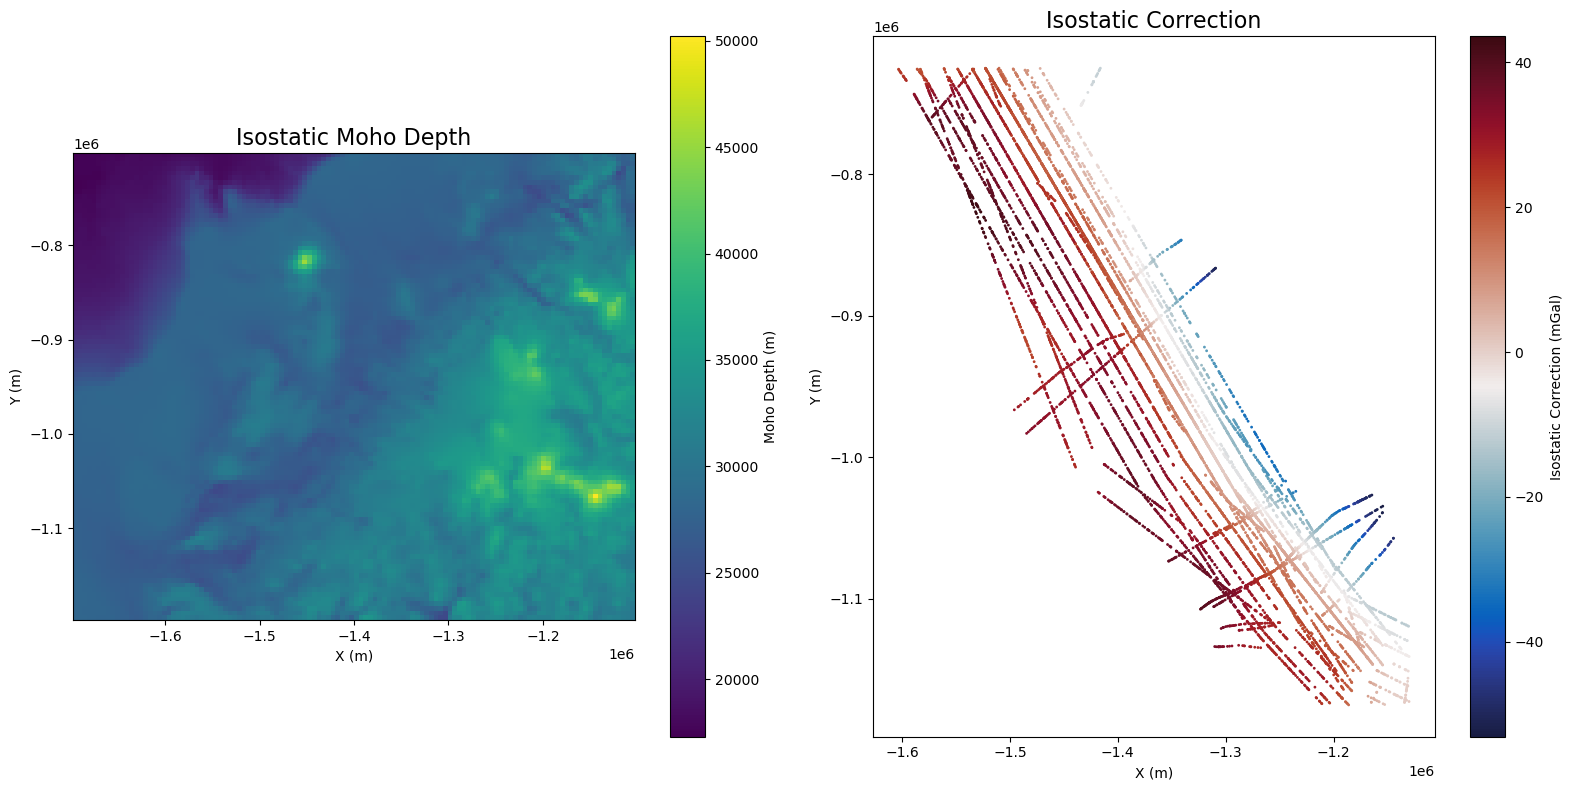

In [43]:
#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

#Plot Moho Depth
ax = axs[0]
moho_plot = ax.imshow(
    moho_depth,
    extent=[x.min(), x.max(), y.min(), y.max()],
    origin='lower',
    cmap='viridis'
)
ax.set_title('Isostatic Moho Depth', fontsize=16)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.colorbar(moho_plot, ax=ax, orientation='vertical', label='Moho Depth (m)')

#Plot Isostatic Correction
ax = axs[1]
iso_correction_plot = ax.scatter(
    iso_df['polar_stereo_x'],
    iso_df['polar_stereo_y'],
    c=iso_df['iso_correction'],
    s=1,
    cmap=cmocean.cm.balance
)
ax.set_title('Isostatic Correction', fontsize=16)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.colorbar(iso_correction_plot, ax=ax, orientation='vertical', label='Isostatic Correction (mGal)')

plt.tight_layout()
plt.show()

### 4. Make a figure of the free air anomaly, Bouguer disturbance, and isostatic disturbance

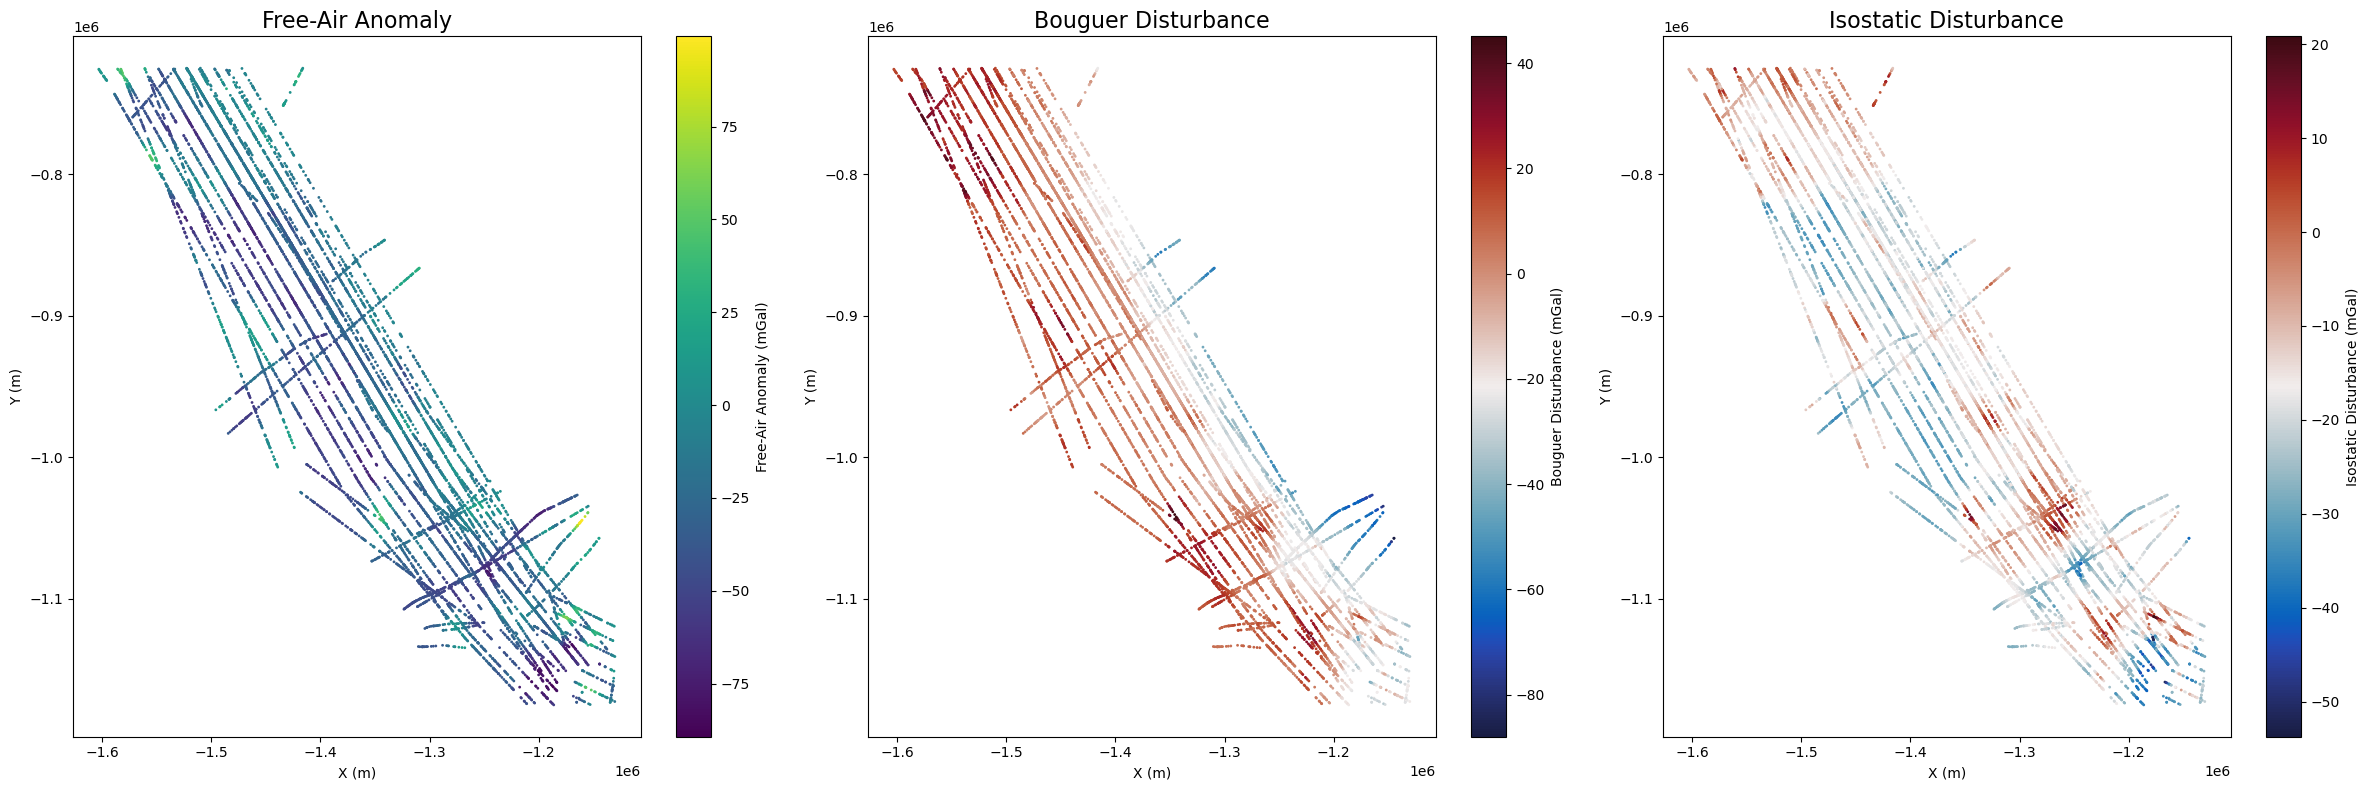

In [45]:
free_air_anomaly = merged_data['faa140'].values
    
#Create subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

#Define colormaps
cmap_anomaly = plt.cm.viridis
cmap_disturbance = cmocean.cm.balance

#Plot Free-Air Anomaly
ax = axs[0]
faa_plot = ax.scatter(
    iso_df['polar_stereo_x'],
    iso_df['polar_stereo_y'],
    c=iso_df['free_air_anomaly'],
    s=1,
    cmap=cmap_anomaly
)
ax.set_title('Free-Air Anomaly', fontsize=16)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.colorbar(faa_plot, ax=ax, orientation='vertical', label='Free-Air Anomaly (mGal)')

#Plot Bouguer Disturbance
ax = axs[1]
bouguer_plot = ax.scatter(
    iso_df['polar_stereo_x'],
    iso_df['polar_stereo_y'],
    c=iso_df['bouguer_disturbance'],
    s=1,
    cmap=cmap_disturbance
)
ax.set_title('Bouguer Disturbance', fontsize=16)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.colorbar(bouguer_plot, ax=ax, orientation='vertical', label='Bouguer Disturbance (mGal)')

#Plot Isostatic Disturbance
ax = axs[2]
iso_disturbance_plot = ax.scatter(
    iso_df['polar_stereo_x'],
    iso_df['polar_stereo_y'],
    c=iso_df['isostatic_disturbance'],
    s=1,
    cmap=cmap_disturbance
)
ax.set_title('Isostatic Disturbance', fontsize=16)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.colorbar(iso_disturbance_plot, ax=ax, orientation='vertical', label='Isostatic Disturbance (mGal)')

plt.tight_layout()
plt.show()
